# Importing the standard libraries

In [1]:
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import pathlib
import imutils
import pickle
import cv2
import os

%matplotlib inline

Above, we have the matplotlib and OpenCV (cv2) libraries for image processing, Numpy library will be used to work with arrays and vectors because the images will be treated as numbers, corresponding to their pixel values. The libraries Imutils, Pathlib and OS will be essential to make the verification of directories.

In [2]:
BASE_PATH = 'dataset'

The directory named BASE_PATH has the name of the folder that contains the other two folders with the images that will be used and the .csv files of the bounding boxes of each image.  In the same folder where "dataset" is located we have this .ipynb file. 

In [3]:
IMAGE_PATH = os.path.sep.join([BASE_PATH, 'images'])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, 'annotations'])

So, using the OS library method, we were able to put together the paths to the folder for the images and the .csv files by associating the IMAGE_PATH and ANNOTHS_PATH variables with the directories to the required files.

# Importing the framework and his tools

In [4]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

The Machine Learning platform we will use is TensorFlow and along with it the Keras API. We will test the use of VGG 16 in our prototype, and we will download it from the framework, and we should also import the functions that we will use in building our neural network: 

👉🏼 Flatten to turn it into a 1-dimensional layer, 

👉🏼 Dropout to speed up the learning processing, 

👉🏼 Dense to create the "Fully-Connected Layers", 

👉🏼 Input to define the inputs in our VGG 16. 

We also have other functions for image processing like img_to_array and load_img, and also the ADAM optimizer.

Finally we will use sklearn to split our data into training and testing, and to categorize the classes in one-hot form.

In [10]:
data = []
labels = []
bboxes = []
imagePaths = []

Here we initialize empty lists that will hold some important information in the course of the prototype:


👉🏼 data: Images,

👉🏼 labels: Categories,

👉🏼 bboxes: Bounding Box coordinates (x, y),

👉🏼 imagePaths: The directory of the images.

Now we will go through our .csv files that correspond to the images we are using:

🔸 First column: Image name,

🔸 Second column: Category,

🔸 Third column: Bounding box (bbox) x initial coordinate,

🔸 Fourth column: initial bbox y coordinate,

🔸 Fifth column: end bbox x coordinate,

🔸 Sixth column: final bbox y coordinate.

In [19]:
for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
    rows = open(csvPath).read().strip().split("\n")
    
    for row in rows:
        row = row.split(",")
        
        (filename, label, startX, startY, endX, endY) = row
        
        imagePath = os.path.sep.join([IMAGE_PATH, label, filename])
        
        image = cv2.imread(imagePath)
        
        (h, w) = image.shape[:2]
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

Above, the variable 'row' will store the values taken from the .csv that was performed externally, an example of each of the categories used can be seen below:


🔸 ['145_0054_jpg.rf.5d469949fa7bbacd2a2d996583abede5.jpg', 'Motorbikes', '11', '32', '184', '191']


🔸 ['159_0009_jpg.rf.0016fb51718b8b1b6a997c70fb920aa6.jpg', 'People', '115', '17', '199', '158']


🔸 ['246_0012_jpg.rf.298ce90186d7705adb835b93f2f21903.jpg', 'Wine_Bottle', '11', '5', '92', '63']


Above, the imagePath variable will have stored the location for us to access the images, an example of each of the categories used can be seen below:


🔸 dataset\images\Motorbikes\145_0054_jpg.rf.5d469949fa7bbacd2a2d996583abede5.jpg


🔸 dataset\images\People\159_0009_jpg.rf.0016fb51718b8b1b6a997c70fb920aa6.jpg


🔸 dataset\images\Wine_Bottle\246_0012_jpg.rf.298ce90186d7705adb835b93f2f21903.jpg


So, having the directories, we will "read" them with OpenCV and store them in the variable "image", from where we will be able to extract the characteristics we are interested in as the size of the image and transform the image into an array.

Finally, all the features that are extracted from each image are added to the previously empty lists.

Remember that we will make a change in the size of the images to use VGG 16 CNN.

# Data Processing

In [20]:
data = np.array(data, dtype="float32") / 255.0

labels = np.array(labels)

bboxes = np.array(bboxes, dtype="float32")

imagePaths = np.array(imagePaths)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Here, for each list of values we will work in a different way. For the list that contains the images, we will have to divide the arrays by 255 for the normalization of the data, because the pixel values go from 0 to 255, and leaving 0 to 1 will speed up the learning process.

In the labels list we have the categories, which when we perform the fit_transform method with the LabelBinarizer function from Scikit-learn we will have the one-hot encoding. An example for the category Motorbikes is: [1, 0, 0], for People it is: [0, 1, 0], and for Wine_Bottle is: [0 , 0, 1].

In the list bboxes we have the coordinates of the bounding boxes of the images to be used in the prototype.

And finally, in the list imagePaths we have the directories of the images.

In [21]:
split = train_test_split(data, labels, bboxes, imagePaths, test_size = 0.20, random_state = 42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In the variable "split", we will have stored the outputs from the train_test_split method of Scikit-learn, for splitting our data.

# Model Building

Below, we will see that two variables have been set that contain, respectively, the number of learning "epochs" and the size of the training batch, the latter usually being a power of 2.


In the following lines we are loading the classic VGG 16 neural net with the pre-trained weights and parameters from the ImageNet database, leaving out the Fully Connected layers with the command "include_top = False", so that we can build new 1-dimensional layers responsible for finding the categories we will work in our database.


Right afterwards we set our VGG 16, because we will not train it to update its parameters during learning.


We will build the Fully Connected layers for the Bounding Box coordinate predictions. And then below that the Fully Connected layers for category predictions.

First, bboxHead is responsible for predicting the bounding box (x, y)-coordinates of the object to be categorized in the image. We have a Fuly Connected layer consisting of 128, 64, 32, and 4 nodes, respectively.



The most important part for the bounding box predictions is the final layer:



👉🏼 The 4 nodes corresponding to the coordinates for the top left and top right of the Bounding Box.


👉🏼 We use a sigmoid function to ensure that our predicted output values are in the range [0,1].


Then, softmaxHead, is responsible for predicting the category of the detected object.

In [22]:
import warnings
warnings.filterwarnings('ignore')

NUM_EPOCHS = 20
BATCH_SIZE = 32

vgg = VGG16(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224, 224, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

# Fully-connected layer - bounding box 
bboxHead = Dense(128, activation = "relu")(flatten)
bboxHead = Dense(64, activation = "relu")(bboxHead)
bboxHead = Dense(32, activation = "relu")(bboxHead)
bboxHead = Dense(4, activation = "sigmoid", name = "bounding_box")(bboxHead)

# Fully-connected layer - categorias
softmaxHead = Dense(512, activation = "relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation = "relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation = "softmax", name = "class_label")(softmaxHead)

model = Model(inputs=vgg.input, outputs = (bboxHead, softmaxHead))

losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error",}

lossWeights = {"class_label": 1.0, "bounding_box": 1.0}

opt = Adam(lr = 0.0001)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Furthermore, we have to create some dictionaries that will store important information from our model, especially with respect to the loss. So, the "loss" for the categories, given that we have one-hot coding is "categororial_crossentropy", while the "loss" for the bounding boxes is "mean_squared_error".

We have a "lossWeights" dictionary that will tell the framework how to "weight" each of the layers during training, at an equal rate for both categories and bounding boxes.

We will initialize the ADAM optimizer with the Learning Rate equal to 0.0001

With the optimizer initialized, we compile the model and check the built neural network with model.summary().

In [23]:
model.compile(loss = losses, optimizer = opt, metrics = ["accuracy"], loss_weights = lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

We will also build two more dictionaries to store the training and the test. 

In [24]:
trainTargets = {"class_label": trainLabels,"bounding_box": trainBBoxes}

testTargets = {"class_label": testLabels,"bounding_box": testBBoxes}

# Fit the Model

In [25]:
H = model.fit(trainImages, trainTargets, validation_data = (testImages, testTargets), 
              batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)

Train on 542 samples, validate on 136 samples
Epoch 1/20
542/542 [==============================] - 203s 375ms/sample - loss: 0.8441 - bounding_box_loss: 0.0534 - class_label_loss: 0.7903 - bounding_box_acc: 0.4889 - class_label_acc: 0.6402 - val_loss: 0.2719 - val_bounding_box_loss: 0.0274 - val_class_label_loss: 0.2588 - val_bounding_box_acc: 0.5809 - val_class_label_acc: 0.9485
Epoch 2/20
542/542 [==============================] - 203s 374ms/sample - loss: 0.3170 - bounding_box_loss: 0.0270 - class_label_loss: 0.2900 - bounding_box_acc: 0.5867 - class_label_acc: 0.8967 - val_loss: 0.1630 - val_bounding_box_loss: 0.0247 - val_class_label_loss: 0.1771 - val_bounding_box_acc: 0.5662 - val_class_label_acc: 0.9706
Epoch 3/20
542/542 [==============================] - 201s 371ms/sample - loss: 0.1520 - bounding_box_loss: 0.0219 - class_label_loss: 0.1300 - bounding_box_acc: 0.6328 - class_label_acc: 0.9649 - val_loss: 0.1211 - val_bounding_box_loss: 0.0199 - val_class_label_loss: 0.0853 -

After we trained the model, we will make graphs for performance analysis and save the model.

In [26]:
model.save('Modelo Detecção de Objetos v_01', save_format = 'h5')

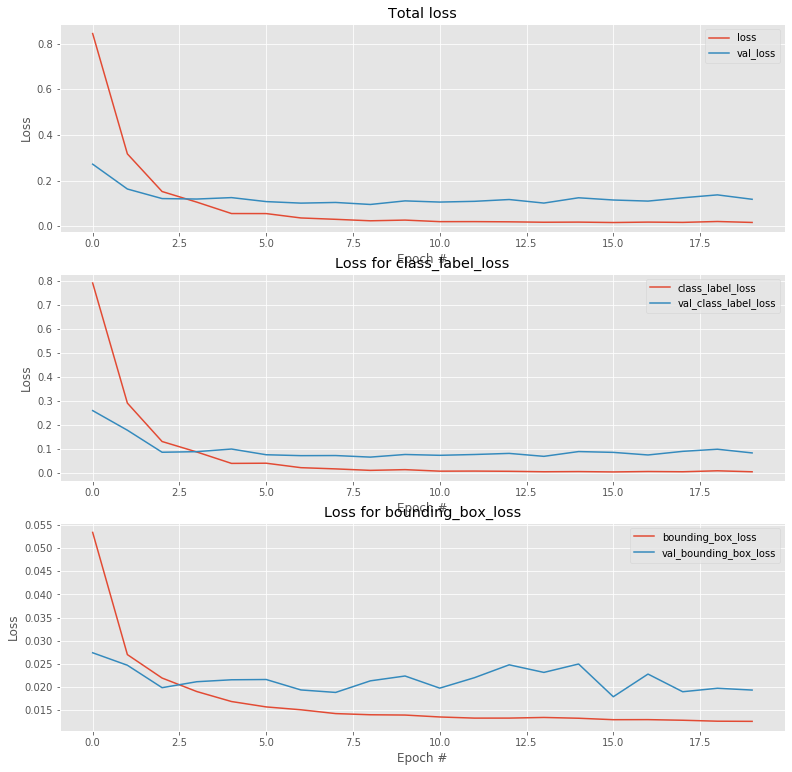

In [27]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize = (13, 13))

for (i, l) in enumerate(lossNames):
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label = "val_" + l)
    ax[i].legend()

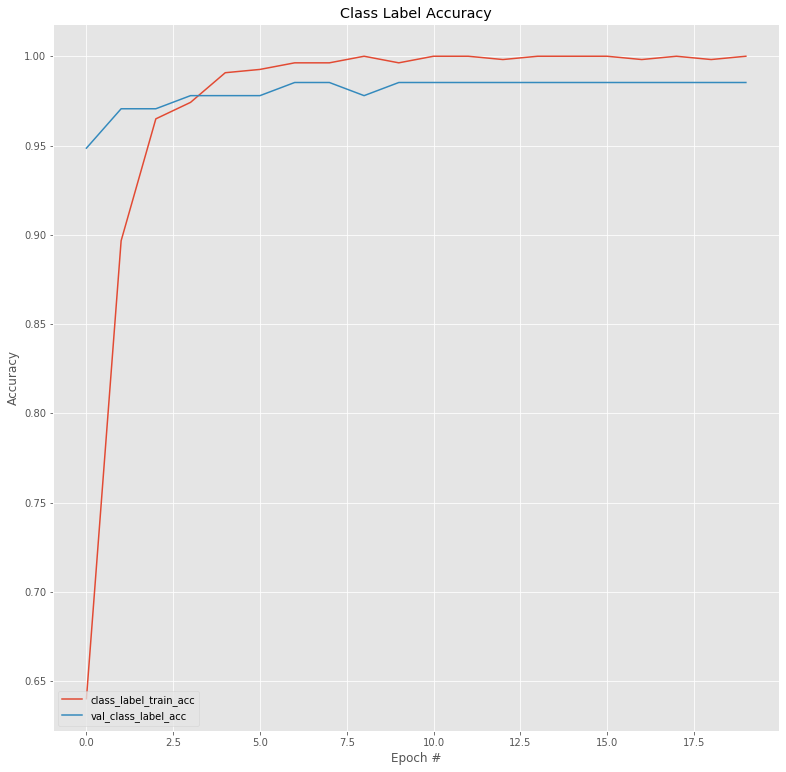

In [28]:
plt.style.use("ggplot")
plt.figure(figsize = (13, 13))
plt.plot(N, H.history["class_label_acc"], label = "class_label_train_acc")
plt.plot(N, H.history["val_class_label_acc"], label = "val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc = "lower left")

# Data Analysis

To start predictions analysis of our model, let's look at how many test examples we have:

In [138]:
len(testImages)

136

What we can do is plot some test images to visualize their predictions. For this we created a function that uses a dictionary for the categories according to the value taken from "testLabels".

In [217]:
SAMPLE = 40

In [218]:
classes = {0: 'Motorbike', 
           1: 'People', 
           2: 'Wine Bottle'}

def plt_sample(X, y, index):
    plt.figure(figsize = (8, 6))
    plt.imshow(X[index])
    class_sample = np.argmax(y[index])
    plt.xlabel(classes[class_sample])

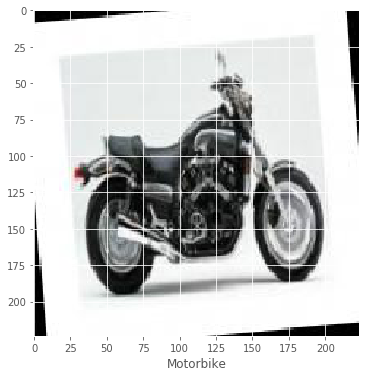

In [219]:
plt_sample(testImages, testLabels, SAMPLE)

We then see that the 41st image in testImages corresponds to a Motorbike, remembering that the label shown on the axis is the original label.

We will now make our model's predictions on the test images.

In [168]:
(boxPreds, labelPreds) = model.predict(testImages)

Above we see the method responsible for making the predictions, in our case we have to predict the class to which the object to be detected belongs, as well as the position of the bounding box.

In [220]:
classPreds = [np.argmax(element) for element in labelPreds]
print('The predicted category is: ', classPreds[SAMPLE])

label_test = classes[classPreds[SAMPLE]]

print('It corresponds to: {}'.format(label_test))

The predicted category is:  0
It corresponds to: Motorbike


So, we just need to change the value of the variable SAMPLE to a range between 0 and 136, which are our test images, so we can check if the category predictions were correct with respect to the image we are analyzing.

For the Bounding box we have to take a list that will contain the predicted coordinates of the model.

In [221]:
(startX, startY, endX, endY) = boxPreds[SAMPLE]

Uma forma de melhorar a precisão da bounding box, faremos um resize na imagem.

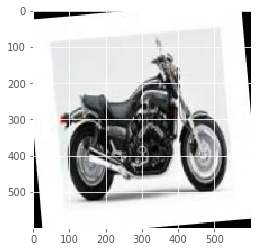

In [222]:
Img = testImages[SAMPLE]

Img = imutils.resize(Img, width=600)
plt.imshow(Img)

Extracting the values for the Bounding Box calculations, we have:

In [223]:
(h, w) = Img.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


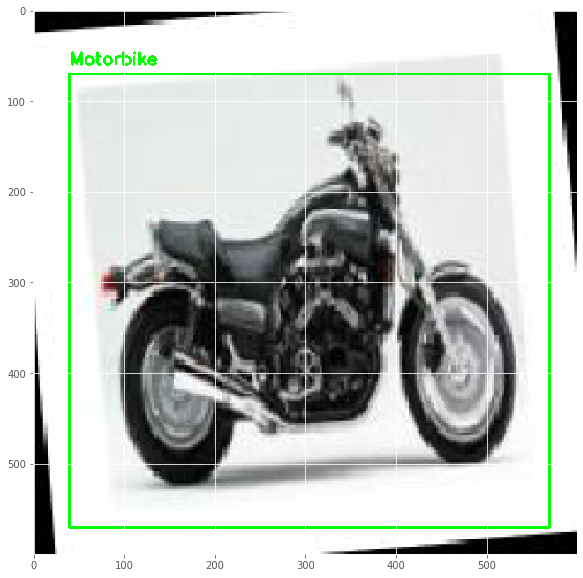

In [224]:
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(Img, label_test, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(Img, (startX, startY), (endX, endY),(0, 255, 0), 2)

plt.figure(figsize = (12,10))
plt.imshow(Img)

# One more example

In [225]:
SAMPLE = 1

classes = {0: 'Motorbike', 
           1: 'People', 
           2: 'Wine Bottle'}

def plt_sample(X, y, index):
    plt.figure(figsize = (8, 6))
    plt.imshow(X[index])
    class_sample = np.argmax(y[index])
    plt.xlabel(classes[class_sample])

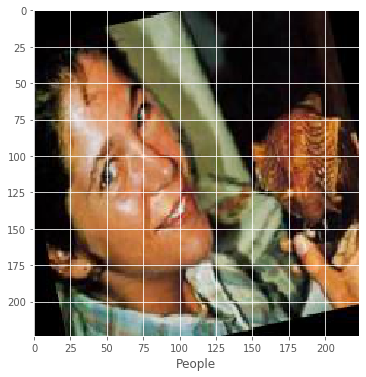

In [226]:
plt_sample(testImages, testLabels, SAMPLE)

In [227]:
classPreds = [np.argmax(element) for element in labelPreds]
print('The predicted category is: ', classPreds[SAMPLE])

label_test = classes[classPreds[SAMPLE]]

print('It corresponds to: {}'.format(label_test))

The predicted category is:  1
It corresponds to: People


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


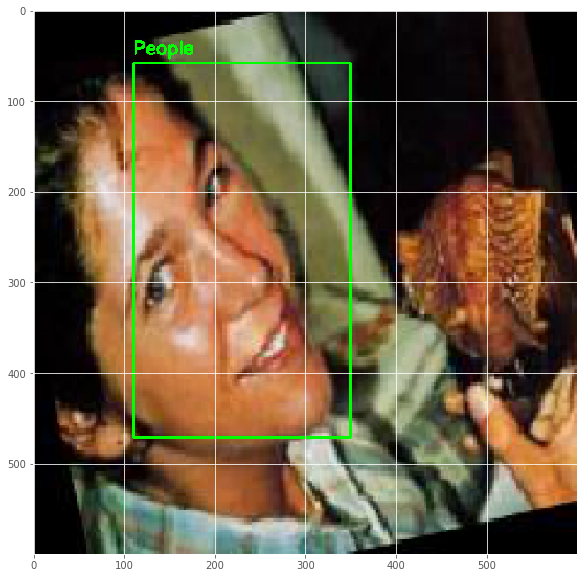

In [228]:
(startX, startY, endX, endY) = boxPreds[SAMPLE]

Img = testImages[SAMPLE]
Img = imutils.resize(Img, width=600)

(h, w) = Img.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(Img, label_test, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(Img, (startX, startY), (endX, endY),(0, 255, 0), 2)

plt.figure(figsize = (12,10))
plt.imshow(Img)